# 2.多臂老虎机
多臂老虎机的每次交互的结果和以往的动作无关，是一种**无状态的强化学习**（stateless reinforcement learning）
不存在状态信息，只有动作和奖励，是最简单的“和环境交互中的学习”的一种形式
以此为介入理解 探索与利用（exploration vs. exploitation）这一特别经典的问题，将帮助初步学习强化学习

1. 基本环境构建
2. 探索与利用平衡算法

导入相关库

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 2.1 基本环境构建：
伯努利多臂老虎机类
懊悔（regret）概念
算法基本框架

### 伯努利多臂老虎机类：

In [2]:
class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """

    def __init__(self, K):
        self.probs = np.round(np.random.uniform(size=K), 2)  # 随机生成 K 个0～1的数,作为拉动每根拉杆的获奖概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # K个中最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)  # 设定固定的随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" % (bandit_10_arm.best_idx, bandit_10_arm.best_prob))
print(bandit_10_arm.probs)

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7200
[0.42 0.72 0.   0.3  0.15 0.09 0.19 0.35 0.4  0.54]


### 懊悔（regret）概念:
定义为当前动作a执行后，期望奖励$Q^*$与实际奖励$Q(a)$的差距（实际操作中不一定是奖励，可以是‘某种抽象收益量’，本实验中为获奖概率）：
$$R(a)=Q^*-Q(a)$$
累积懊悔（cumulative regret）即进行一系列动作后累积的懊悔总量：
$$\sigma_R=\sum_{t=1}^TR(a_t)$$
MAB 问题的目标为最大化累积奖励，如此将等价于最小化累积懊悔


### 算法基本框架:

In [3]:
class Solver:
    """ 多臂老虎机算法基本框架 """

    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数初始为零
        self.regret = 0.   # 累积懊悔
        self.actions = []  # 维护一个列表,记录序列动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, i):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[i]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError("This method has not been implemented yet.")

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            i = self.run_one_step()  # 根据不同算法决策决定选择哪一根拉杆
            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)

以上尚未实现的设计策略即平衡 *探索和利用* ：
探索（exploration）是指尝试拉动更多可能的拉杆，这根拉杆不一定会获得最大的奖励，但这种方案能够摸清楚所有拉杆的获奖情况。例如，对于一个 10 臂老虎机，把所有的拉杆都拉动一下才知道哪根拉杆可能获得最大的奖励。
利用（exploitation）是指拉动已知期望奖励最大的那根拉杆，由于已知的信息仅仅来自有限次的交互观测，所以当前的最优拉杆不一定是全局最优的。

以下将介绍一些经典的算法来平衡 *探索和利用* ：

## 2.2 探索与利用的平衡
ϵ-贪心算法
上置信界算法
汤普森采样算法

### ϵ-贪心（Greedy）算法：

In [4]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪（Greedy）算法,继承Solver类 """
    def __init__(self, bandit, epsilon, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)  # 初始化父类
        self.epsilon = epsilon
        # 初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
            
        r = self.bandit.step(k)  # 得到本次动作的奖励（1/0）
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  # 增量式更新
        return k

In [5]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  # 增量式更新

        return k

增量式更新公式推导（r为奖励1或0）：
$$\begin{aligned}
Q_{k} & =\frac{1}{k}\sum_{i=1}^kr_i \\
 & =\frac{1}{k}\left(r_k+\sum_{i=1}^{k-1}r_i\right) \\
 & =\frac{1}{k}(r_k+(k-1)Q_{k-1}) \\
 & =\frac{1}{k}(r_k+kQ_{k-1}-Q_{k-1}) \\
 & =Q_{k-1}+\frac{1}{k}[r_k-Q_{k-1}]
\end{aligned}$$

生成累积懊悔随时间变化的图像：

In [6]:
def plot_results(solvers, solver_names):
    """
    输入solvers是一个列表,列表中的每个元素是一种特定的策略（当前仅有一个ϵ-贪心）
    solver_names也是一个列表,存储每个策略的名称
    """
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

epsilon-贪婪算法的累积懊悔为： 1008.9699999999966


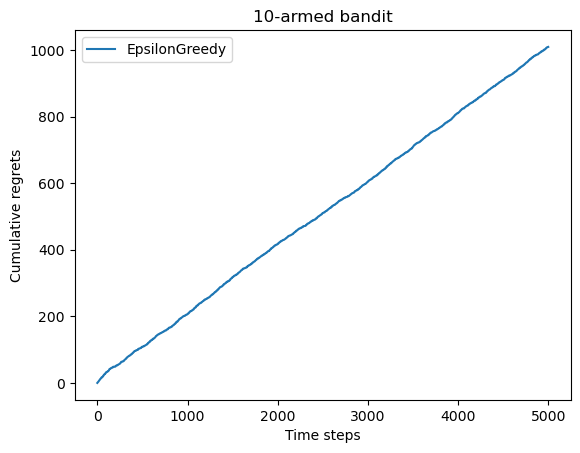

In [7]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.5)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

epsilon值衰减的贪婪算法的累积懊悔为： 10.07


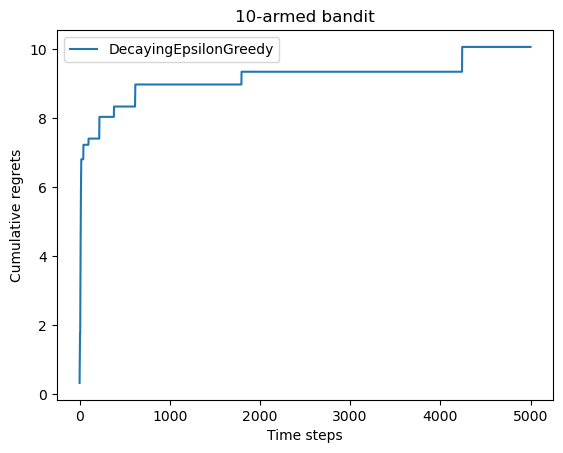

In [8]:
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

对比两个图像，可见前期做一定的 *探索* ，后期大概率 *利用* ，而非在整个学习阶段采用固定的探索率

### 上置信界算法：
假设一个动作只执行过一次，另一个动作已经执行过许多次了，对它的奖励分布已经有了大致的把握。在这种情况下应该探索哪一种动作呢？
很显然只执行过一次的动作，不确定性更大，所具备的探索价值更高
在此引入**不确定性度量$U(a)$**,来衡量某个动作所具备的探索价值

**上置信界（upper confidence bound，UCB）算法** 就是一种经典的基于不确定性的策略算法，它的思想用到了一个非常著名的数学原理：霍夫丁不等式（Hoeffding's inequality），其数学表达公式为：
$$
P(|\overline{X}-\mu|\geq\epsilon)\leq2e^{\left(-\frac{2n\epsilon^2}{\sum_{i=1}^n(b_i-a_i)^2}\right)}
$$
霍夫丁不等式提供了一个关于 **样本均值偏离期望值的概率的上界$2p$(不等式右侧)**，并且这个上界随着样本量 n 的增大而迅速收敛
相比考研概率论所学的切比雪夫不等式，霍夫丁不等式提供了更紧的界限（霍夫丁不等式要求数据是独立同分布的，并且每个随机变量的取值范围是已知的）

在本实验中各个拉杆动作的奖励概率取值范围均为[0,1]，其中$ϵ=U(a)$即**不确定性度量**，随着样本量 n 的增大不确定性度量会收敛减小，正好对应某个动作探索价值的降低.
公式简化为：
$$
P(|\overline{X}-\mu|\geq\epsilon)\leq2e^{-2n\epsilon^2}
$$
假设给定一个概率的上界$p$,可求每个动作相应的不确定性度量：
$$p=e^{-2N_t(a)U_t(a)^2}$$
$$\hat{U}_t(a)=\sqrt{\frac{-\log p}{2N_t(a)}}$$
在具体的实现过程中，设置$p=\frac{1}{t}$ ，并且在分母中为拉动每根拉杆的次数加上常数 1，以免出现分母为 0 的情形，即此时$\hat{U}_t(a)=\sqrt{\frac{\log t}{2(N_t(a)+1)}}$ 。同时，设定一个系数c来控制不确定性的比重，此时$a=\arg\max_{a\in\mathcal{A}}\left(\hat{Q}\left(a\right)+c\cdot\hat{U}\left(a)\right.\right)$


In [9]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

上置信界算法的累积懊悔为： 79.64000000000003


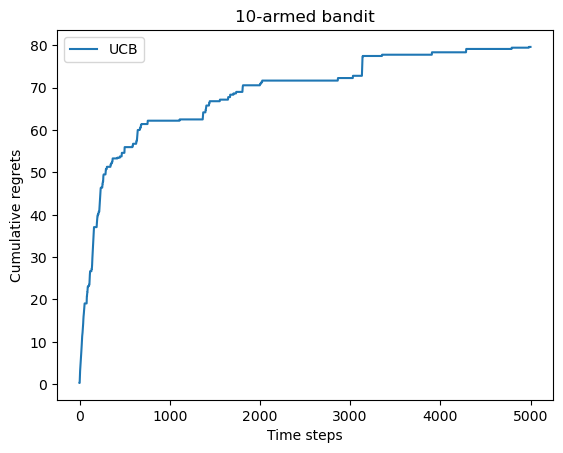

In [10]:
np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

### 汤普森采样算法：
**蒙特卡洛采样** 是一种通过大量随机样本估计问题解的统计方法，它的核心思想是通过模拟大量随机样本，利用样本的均值来逼近期望值或其他所需的量。
**汤普森采样（Thompson Sampling, TS）** 就是一种蒙特卡洛采样方法，常用于解决MAB的 **贝叶斯优化算法**。
它通过模拟每个臂的概率分布来做出决策，先初始化一个 **先验分布**（Beta 分布），然后在不断重复选择、拉动和更新的过程中根据观察到的奖励更新**后验分布**，并基于这些分布进行随机采样，从而选择最优的臂进行拉取：

In [11]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照多个Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

汤普森采样算法的累积懊悔为： 47.86


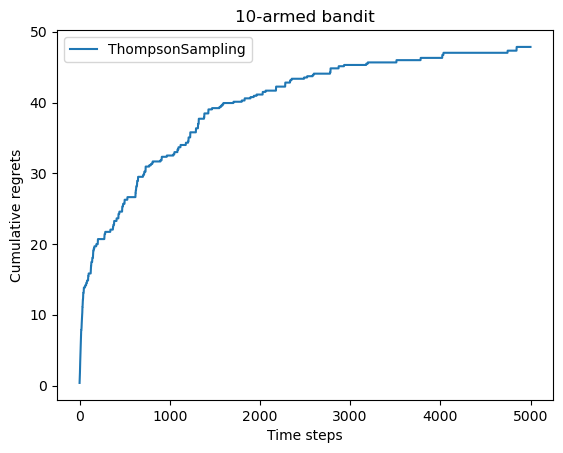

In [12]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

## 总结
**ϵ-贪婪算法**的累积懊悔是随时间线性增长的，而 **ϵ-衰减贪婪算法、上置信界算法、汤普森采样算法** 的累积懊悔随时间次线性增长的（具体为对数形式增长），算法性能更优。
